<a href="https://colab.research.google.com/github/yakupusame/HousePrice/blob/master/HousePrice6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import sklearn.metrics as metrics
import math
import pandas_profiling

In [42]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [43]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [44]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [45]:
train['train'] = 1
test['train'] = 0
df = pd.concat([train,test],axis=0 ,sort=False)

In [46]:
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


In [47]:
NAN = [(i,df[i].isna().sum(), df[i].isna().mean()*100) for i in df]
NAN = pd.DataFrame(NAN , columns=['column__name','count','percentage'])
NAN.sort_values('percentage',ascending=False).head(10)


,column__name,count,percentage
72,PoolQC,2909,99.657417
74,MiscFeature,2814,96.402878
6,Alley,2721,93.216855
73,Fence,2348,80.438506
80,SalePrice,1459,49.982871
57,FireplaceQu,1420,48.646797
3,LotFrontage,486,16.649538
59,GarageYrBlt,159,5.447071
63,GarageQual,159,5.447071
60,GarageFinish,159,5.447071


In [48]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


In [49]:
df = df.drop(['PoolQC','MiscFeature','Alley','Fence'] ,axis=1)

In [50]:
cat_df = df.select_dtypes(include=['object'])
num_df = df.select_dtypes(exclude=['object'])


In [51]:
num_df.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
train              int64
dtype: object

In [52]:
cat_na = cat_df.isnull().sum().sort_values(ascending =False)
print('number of na values \n{}'.format(cat_na))

number of na values 
FireplaceQu      1420
GarageCond        159
GarageQual        159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MSZoning            4
Utilities           2
Functional          2
Electrical          1
KitchenQual         1
SaleType            1
Exterior2nd         1
Exterior1st         1
LandContour         0
BldgType            0
LotShape            0
LotConfig           0
LandSlope           0
Street              0
Neighborhood        0
Condition1          0
Condition2          0
SaleCondition       0
HouseStyle          0
RoofStyle           0
RoofMatl            0
ExterQual           0
ExterCond           0
Heating             0
HeatingQC           0
CentralAir          0
PavedDrive          0
Foundation          0
dtype: int64


In [53]:
cat_none = ['GarageCond','GarageQual','GarageFinish','GarageType','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']

cat_df[cat_none] = cat_df[cat_none].fillna('None')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [54]:
cat_df.isnull().sum()


MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinType2        0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType          0
GarageFinish        0
GarageQual          0
GarageCond          0
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64

In [55]:
cat_df.drop(['FireplaceQu'],axis=1 , inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [56]:
cat_df.isnull().sum()

MSZoning          4
Street            0
LotShape          0
LandContour       0
Utilities         2
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       1
Exterior2nd       1
MasVnrType       24
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinType2      0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       1
Functional        2
GarageType        0
GarageFinish      0
GarageQual        0
GarageCond        0
PavedDrive        0
SaleType          1
SaleCondition     0
dtype: int64

In [57]:
cat_none2 = ['KitchenQual' ,'Exterior1st','Exterior2nd','SaleType' , 'Functional','Electrical','MasVnrType','Utilities','MSZoning']

cat_df[cat_none2] = cat_df[cat_none2].fillna(cat_df.mode().iloc[0])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [58]:
cat_df.isnull().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64

In [59]:
num_df.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64

In [60]:
num_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,208500.0,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,181500.0,1
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,223500.0,1
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,140000.0,1
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,250000.0,1


In [61]:
num_none = ['GarageArea','GarageCars','BsmtHalfBath','BsmtFullBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1',
            'MasVnrArea','LotFrontage']
num_df[num_none] = num_df[num_none].fillna(num_df.mean().iloc[0])          

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [62]:
num_df['GarageYrBlt'] = num_df['GarageYrBlt'].fillna(num_df.median().iloc[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
num_df.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt         0
GarageCars          0
GarageArea          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64

In [64]:
np.unique(num_df['MasVnrArea'])

array([0.000e+00, 1.000e+00, 3.000e+00, 1.100e+01, 1.400e+01, 1.600e+01,
       1.800e+01, 2.000e+01, 2.200e+01, 2.300e+01, 2.400e+01, 2.700e+01,
       2.800e+01, 3.000e+01, 3.100e+01, 3.200e+01, 3.400e+01, 3.600e+01,
       3.800e+01, 3.900e+01, 4.000e+01, 4.100e+01, 4.200e+01, 4.400e+01,
       4.500e+01, 4.600e+01, 4.700e+01, 4.800e+01, 5.000e+01, 5.100e+01,
       5.200e+01, 5.300e+01, 5.400e+01, 5.600e+01, 5.700e+01, 5.800e+01,
       6.000e+01, 6.200e+01, 6.300e+01, 6.400e+01, 6.500e+01, 6.600e+01,
       6.700e+01, 6.800e+01, 6.900e+01, 7.000e+01, 7.200e+01, 7.400e+01,
       7.500e+01, 7.600e+01, 8.000e+01, 8.100e+01, 8.200e+01, 8.400e+01,
       8.500e+01, 8.600e+01, 8.700e+01, 8.800e+01, 8.900e+01, 9.000e+01,
       9.100e+01, 9.200e+01, 9.400e+01, 9.500e+01, 9.600e+01, 9.700e+01,
       9.800e+01, 9.900e+01, 1.000e+02, 1.010e+02, 1.020e+02, 1.040e+02,
       1.050e+02, 1.060e+02, 1.080e+02, 1.090e+02, 1.100e+02, 1.120e+02,
       1.130e+02, 1.140e+02, 1.150e+02, 1.160e+02, 

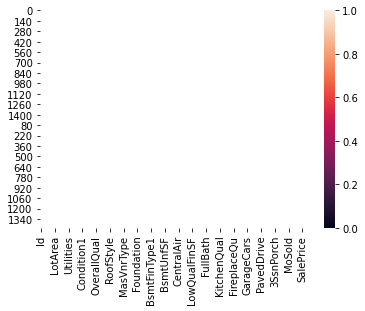

In [65]:
import seaborn as sns
sns.heatmap(df.isnull(),linecolor='white',linewidths=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd70fb8bf28>,
      dtype=object)

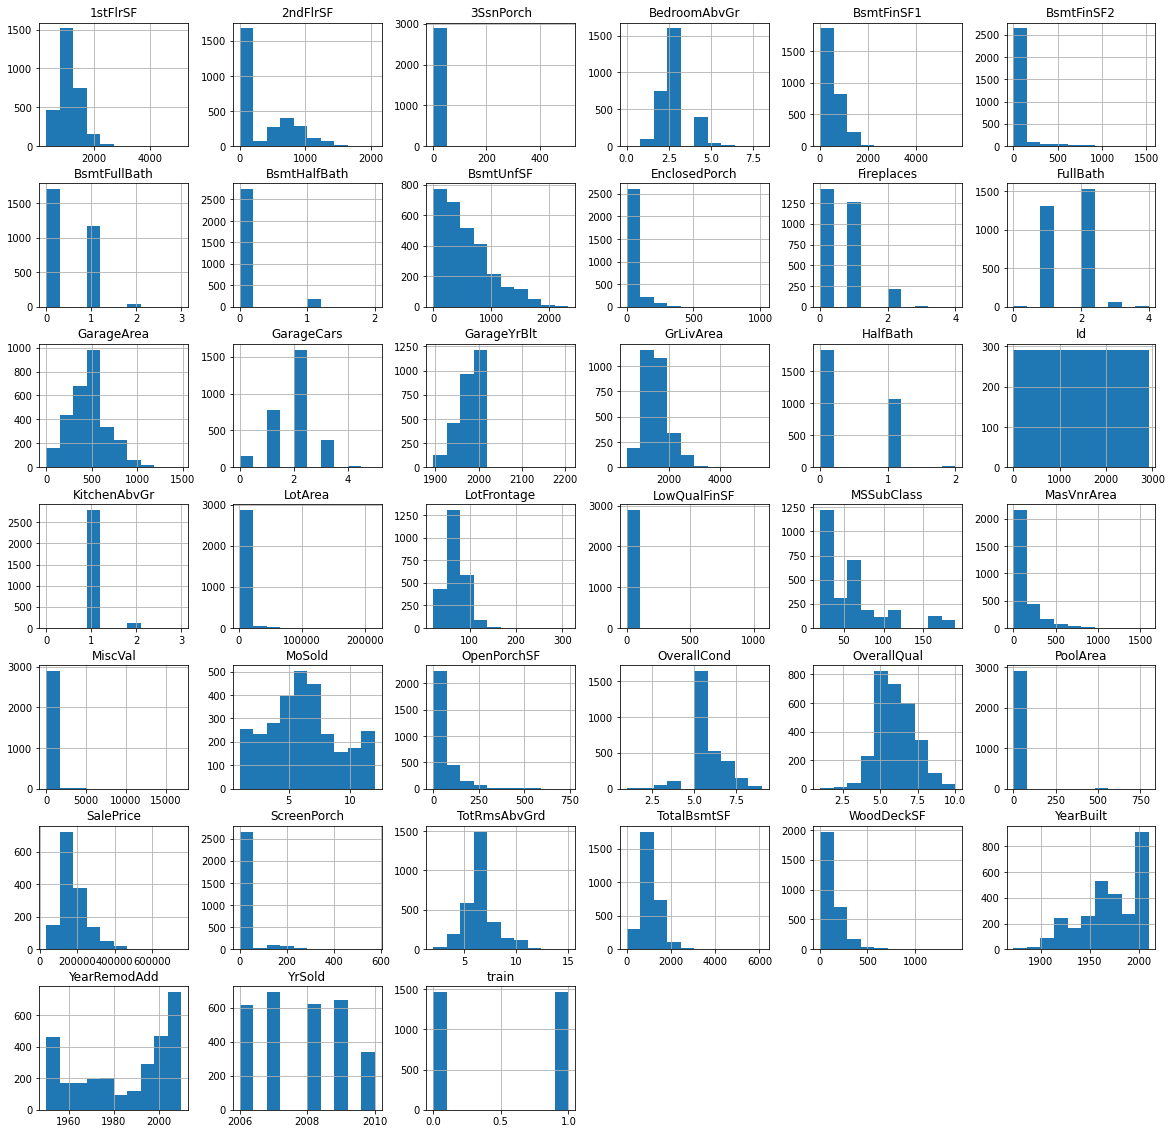

In [66]:
df.hist(figsize=(20,20))

In [67]:
num_df = num_df.drop(['3SsnPorch','BsmtFinSF2','BsmtHalfBath','BsmtFullBath','GarageCars','EnclosedPorch','GarageCars','LotArea',
         'LowQualFinSF','PoolArea','MiscVal','ScreenPorch','KitchenAbvGr'],axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd70ea77550>,
      dtype=object)

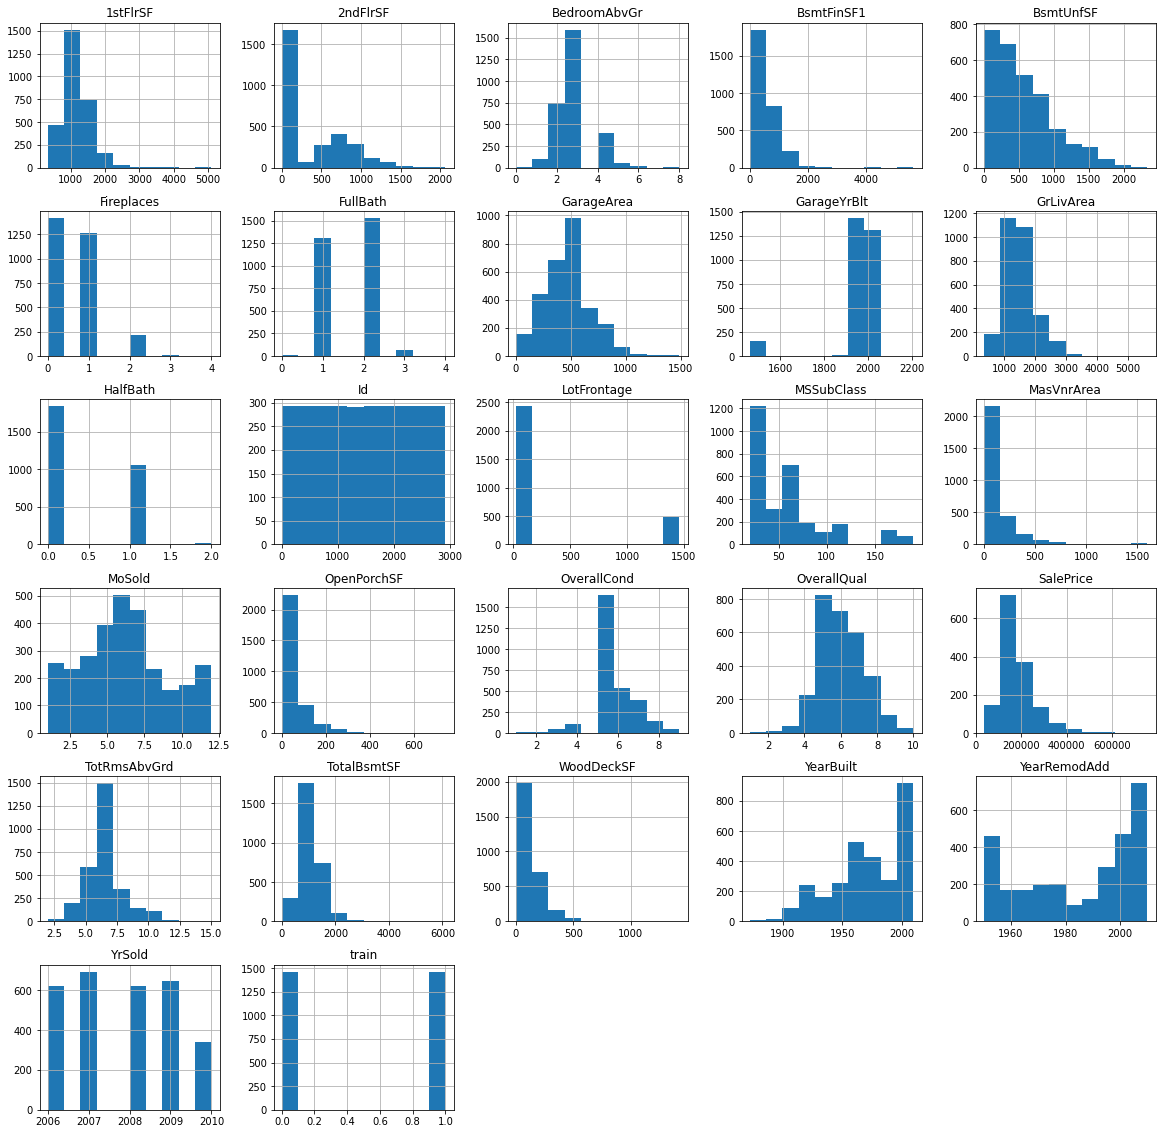

In [68]:
num_df.hist(figsize = (20,20))

In [69]:
cat_df.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [70]:
cat_df.shape

(2919, 38)

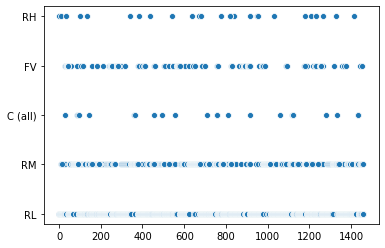

In [71]:
sns.scatterplot(data=cat_df['MSZoning'])

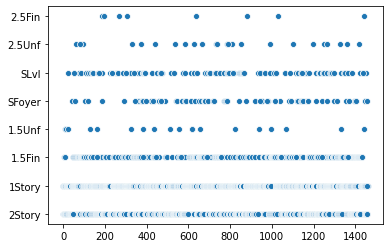

In [72]:
sns.scatterplot(data=cat_df['HouseStyle'])

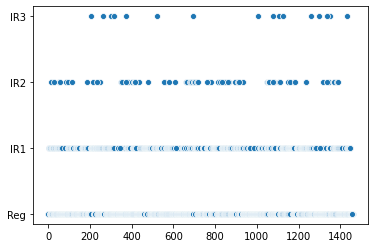

In [73]:
sns.scatterplot(data=cat_df['LotShape'])

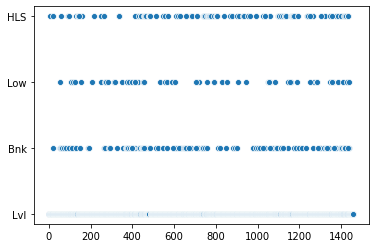

In [74]:
sns.scatterplot(data=cat_df['LandContour'])

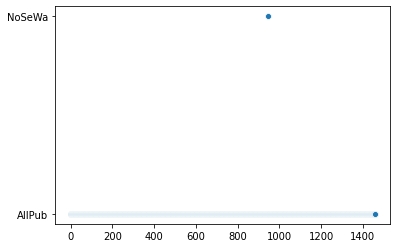

In [75]:
sns.scatterplot(data=cat_df['Utilities'])

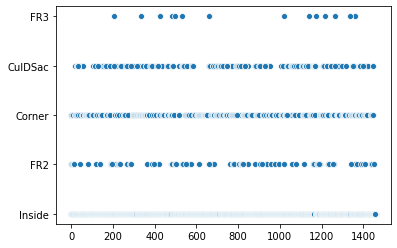

In [76]:
sns.scatterplot(data=cat_df['LotConfig'])

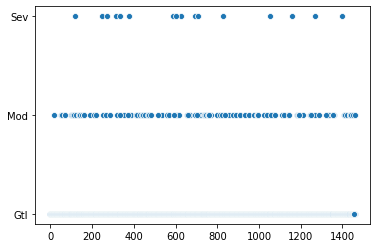

In [77]:
sns.scatterplot(data=cat_df['LandSlope'])

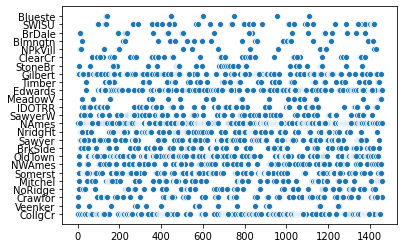

In [78]:
sns.scatterplot(data=cat_df['Neighborhood'])

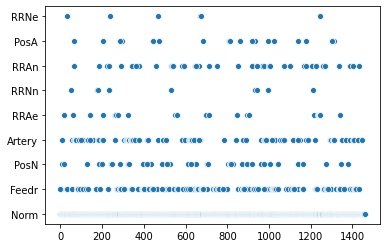

In [79]:
sns.scatterplot(data=cat_df['Condition1'])

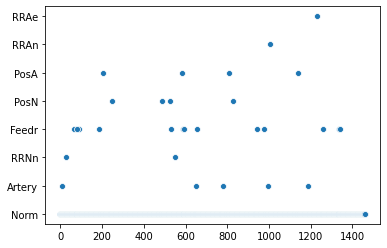

In [80]:
sns.scatterplot(data=cat_df['Condition2'])

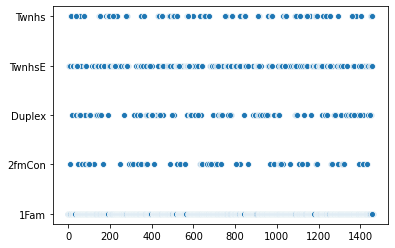

In [81]:
sns.scatterplot(data=cat_df['BldgType'])

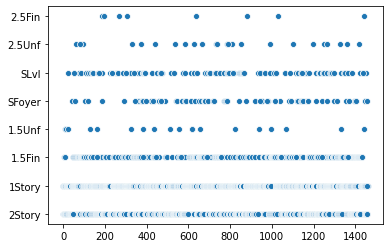

In [82]:
sns.scatterplot(data=cat_df['HouseStyle'])

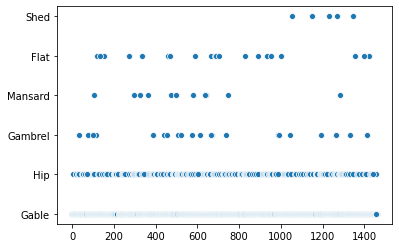

In [83]:
sns.scatterplot(data=cat_df['RoofStyle'])

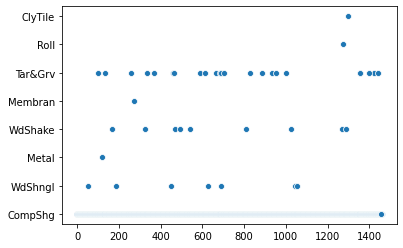

In [84]:
sns.scatterplot(data=cat_df['RoofMatl'])

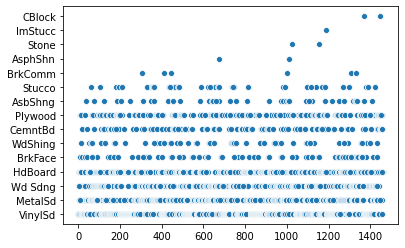

In [85]:
sns.scatterplot(data=cat_df['Exterior1st'])

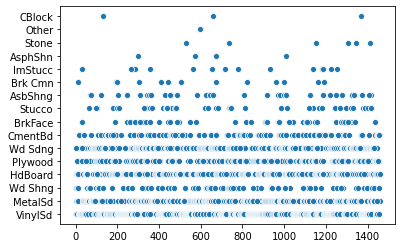

In [86]:
sns.scatterplot(data=cat_df['Exterior2nd'])

In [87]:
cat_df.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

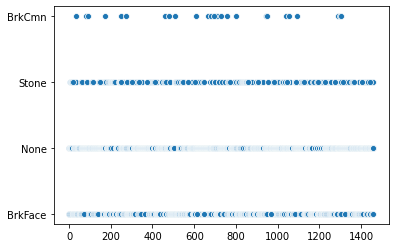

In [88]:
sns.scatterplot(data=cat_df['MasVnrType'])

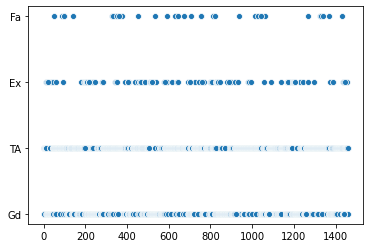

In [89]:
sns.scatterplot(data=cat_df['ExterQual'])

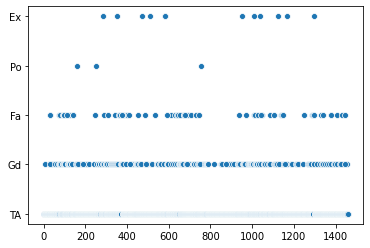

In [90]:
sns.scatterplot(data=cat_df['ExterCond'])

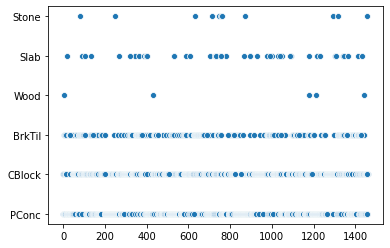

In [91]:
sns.scatterplot(data=cat_df['Foundation'])

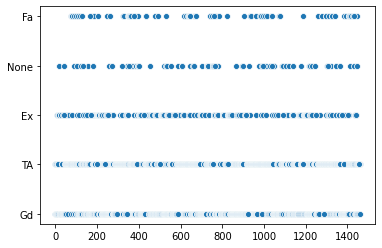

In [92]:
sns.scatterplot(data=cat_df['BsmtQual'])

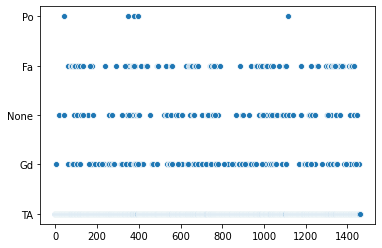

In [93]:
sns.scatterplot(data=cat_df['BsmtCond'])

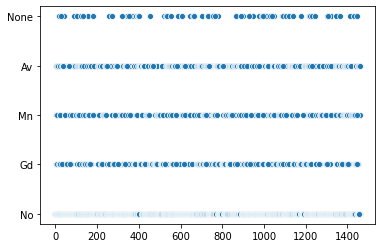

In [94]:
sns.scatterplot(data=cat_df['BsmtExposure'])

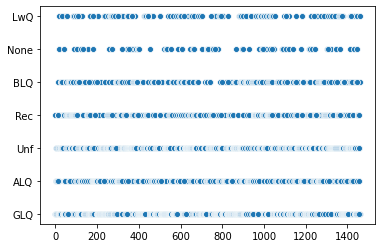

In [95]:
sns.scatterplot(data=cat_df['BsmtFinType1'])

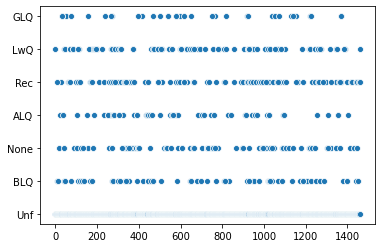

In [96]:
sns.scatterplot(data=cat_df['BsmtFinType2'])

In [97]:
cat_df.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

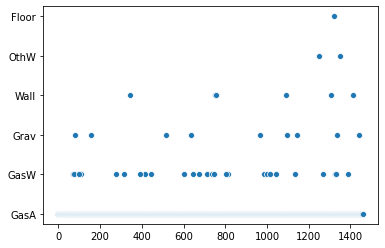

In [98]:
sns.scatterplot(data=cat_df['Heating'])

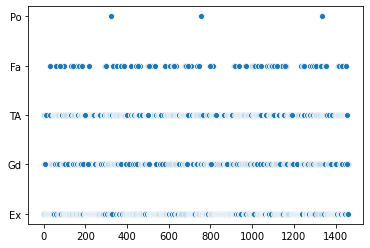

In [99]:
sns.scatterplot(data=cat_df['HeatingQC'])

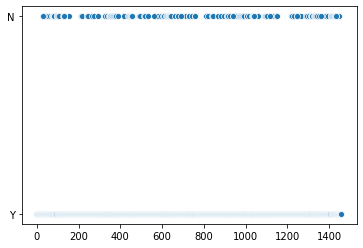

In [100]:
sns.scatterplot(data=cat_df['CentralAir'])

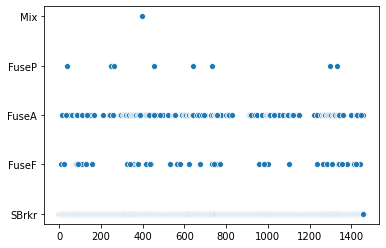

In [101]:
sns.scatterplot(data=cat_df['Electrical'])

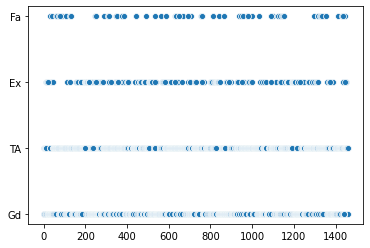

In [102]:
sns.scatterplot(data=cat_df['KitchenQual'])

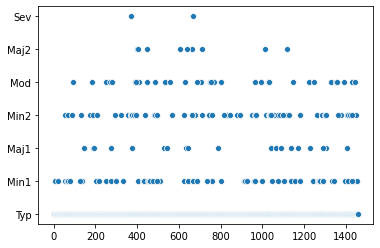

In [103]:
sns.scatterplot(data=cat_df['Functional'])

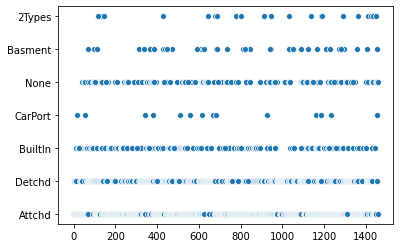

In [104]:
sns.scatterplot(data=cat_df['GarageType'])

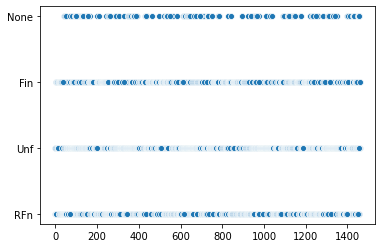

In [105]:
sns.scatterplot(data=cat_df['GarageFinish'])

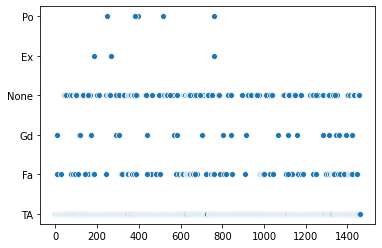

In [106]:
sns.scatterplot(data=cat_df['GarageQual'])

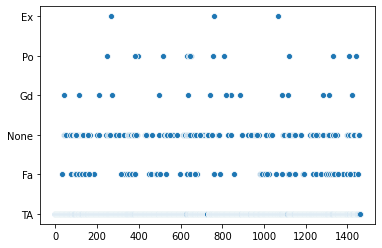

In [107]:
sns.scatterplot(data=cat_df['GarageCond'])

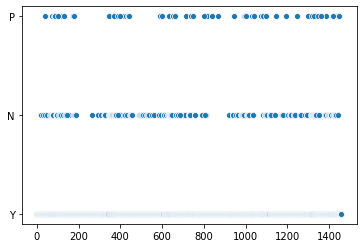

In [108]:
sns.scatterplot(data=cat_df['PavedDrive'])


In [111]:
np.unique(cat_df['PavedDrive'])

array(['N', 'P', 'Y'], dtype=object)

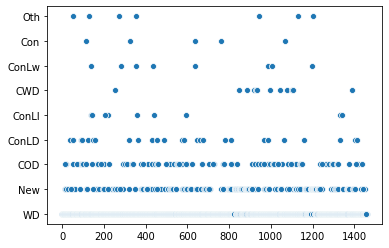

In [109]:
sns.scatterplot(data=cat_df['SaleType'])

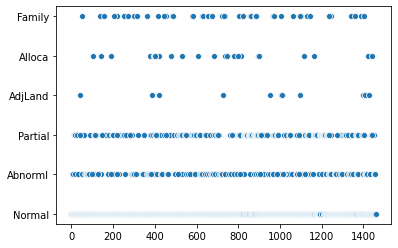

In [110]:
sns.scatterplot(data=cat_df['SaleCondition'])

In [112]:
cat_df.drop(['Utilities','CentralAir','PavedDrive','Condition2','RoofMatl','Heating','Street'],axis = 1)


,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,WD,Normal
1,RL,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,SBrkr,TA,Typ,Attchd,RFn,TA,TA,WD,Normal
2,RL,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,WD,Normal
3,RL,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,WD,Abnorml
4,RL,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,SBrkr,TA,Typ,None,None,None,None,WD,Normal
1455,RM,Pave,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,SBrkr,TA,Typ,CarPort,Unf,TA,TA,WD,Abnorml
1456,RL,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,SBrkr,TA,Typ,Detchd,Unf,TA,TA,WD,Abnorml
1457,RL,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,TA,SBrkr,TA,Typ,None,None,None,None,WD,Normal


In [113]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder()
#cat_df = encoder.fit_transform(cat_df).toarray()

In [114]:
cat_df.shape

(2919, 243)

In [115]:
cat_df

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])